In [ ]:
%%time
%cd '/content/drive/MyDrive/Colab Notebooks/OSAIL DL Task Submission'

/content/drive/MyDrive/Colab Notebooks/OSAIL DL Task Submission
CPU times: user 3.1 ms, sys: 0 ns, total: 3.1 ms
Wall time: 3.71 ms


**Imports**

In [ ]:
%%time
import tensorflow as tf
#print(tf.__version__)
from tensorflow import keras
import os
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
import random
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data 


CPU times: user 3.08 s, sys: 1.14 s, total: 4.22 s
Wall time: 9.09 s


**Prepare Dataset**

In [ ]:
####### resize dataset (224,224) to size (112,112) to avoid out of memory #######
%%time
Pool2_path = '/content/drive/MyDrive/Colab Notebooks/OSAIL_Data/Unlabeled'
dir = os.listdir(Pool2_path)
Pool2 = []
for i in range(len(dir)):
   img = cv2.imread(Pool2_path+'/'+dir[i])
   img = cv2.resize(img,(112,112))
   Pool2.append(img)
Pool2 = np.array(Pool2)
print(Pool2.shape, 'Unlabeled Pool2.shape')
Pool2_train = Pool2[:5947]
Pool2_test = Pool2[5947:]
print(Pool2_train.shape[0], 'train samples')
print(Pool2_test.shape[0], 'test samples')

(7434, 112, 112, 3) Unlabeled Pool2.shape
5947 train samples
1487 test samples
CPU times: user 8.95 s, sys: 4.37 s, total: 13.3 s
Wall time: 3min 3s


**Visualization of some of Unlabeled data**

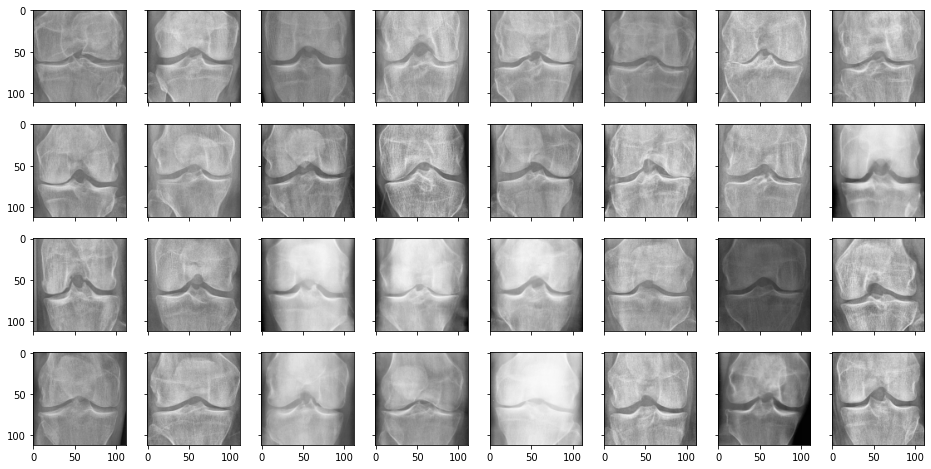

CPU times: user 7.26 s, sys: 125 ms, total: 7.38 s
Wall time: 7.16 s


In [ ]:
%%time
sample_images = Pool2_train[:32]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )
for ax, image in zip(grid, sample_images):
  ax.imshow(image,cmap='gray')

plt.show()

**Data Generator with Patch Augmentation**

In [ ]:
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=112, dim=(112, 112),n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size
      self.y = y
      self.X = X
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle == True:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
      X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1],self.n_channels))
      y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1],self.n_channels))
      
      x = y = np.random.randint(0, 111, 1)[0]
      w = h = np.random.randint(1, 30, 1)[0]

      for i, idx in enumerate(idxs):
        tmp_image = self.X[idx].copy()

        mask = np.full(tmp_image.shape, 255, np.uint8)
        mask[y:y+h,x:x+w] = 0
        res = cv2.bitwise_and(tmp_image, mask)

        X_batch[i,] = res/255
        y_batch[i] = self.y[idx]/255
        
      return X_batch, y_batch

In [ ]:
%%time
traingen = createAugment(Pool2_train, Pool2_train)
testgen = createAugment(Pool2_test, Pool2_test)

CPU times: user 589 µs, sys: 0 ns, total: 589 µs
Wall time: 685 µs


**Visualization of some of patched data**

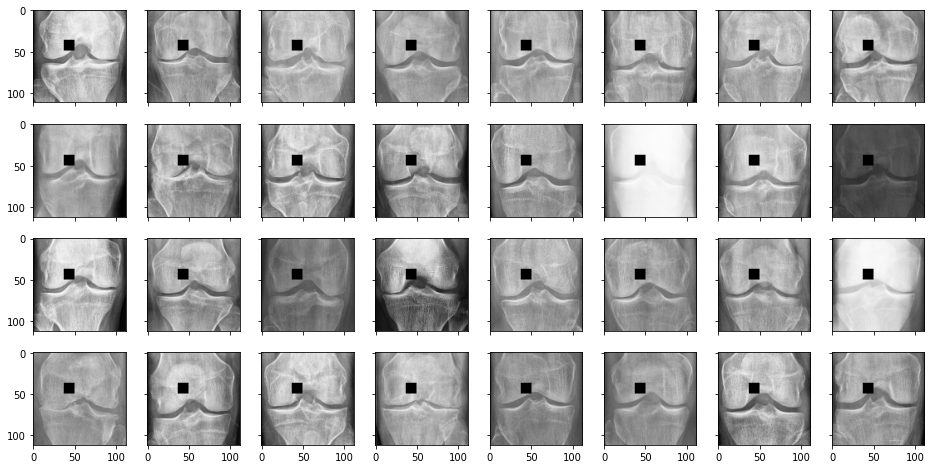

CPU times: user 7.32 s, sys: 250 ms, total: 7.57 s
Wall time: 7.37 s


In [ ]:
%%time
sample_idx = 5 ## Change this to see different batches

sample_images, sample_labels = traingen[sample_idx]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image,cmap='gray')

plt.show()

## **Unet model in Python**

In [ ]:
%%time

inputs = keras.layers.Input((112, 112,3))

conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = keras.layers.concatenate([keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
up7 = keras.layers.concatenate([keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
up8 = keras.layers.concatenate([keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
up9 = keras.layers.concatenate([keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
conv10 = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)


CPU times: user 738 ms, sys: 417 ms, total: 1.16 s
Wall time: 3.05 s


In [ ]:
%%time
unet_like = Model(inputs=inputs, outputs=conv10)
unet_like.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_like.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 112, 112, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
%%time
ch = ModelCheckpoint('weights.h5',monitor= "val_accuracy",save_weights_only=False,save_best_only=False,mode='max')
callbacks = [ch]
unet_like.fit(traingen, validation_data=testgen, 
          epochs=20, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=True,
          callbacks=callbacks)

Epoch 1/20
53/53 [==============================] - 18s 323ms/step - loss: 0.5916 - accuracy: 0.3231 - val_loss: 0.5909 - val_accuracy: 0.2988
Epoch 2/20
53/53 [==============================] - 17s 317ms/step - loss: 0.5914 - accuracy: 0.3274 - val_loss: 0.5904 - val_accuracy: 0.3021
Epoch 3/20
53/53 [==============================] - 18s 326ms/step - loss: 0.5913 - accuracy: 0.3360 - val_loss: 0.5905 - val_accuracy: 0.3080
Epoch 4/20
53/53 [==============================] - 18s 326ms/step - loss: 0.5913 - accuracy: 0.3374 - val_loss: 0.5906 - val_accuracy: 0.3240
Epoch 5/20
53/53 [==============================] - 18s 321ms/step - loss: 0.5915 - accuracy: 0.3468 - val_loss: 0.5910 - val_accuracy: 0.2168
Epoch 6/20
53/53 [==============================] - 18s 326ms/step - loss: 0.5913 - accuracy: 0.3435 - val_loss: 0.5905 - val_accuracy: 0.3618
Epoch 7/20
53/53 [==============================] - 18s 330ms/step - loss: 0.5915 - accuracy: 0.3408 - val_loss: 0.5907 - val_accuracy: 0.4464

**save model**

In [ ]:
%%time
unet_like.save('shima_inpaint_trail1.h5')

CPU times: user 207 ms, sys: 79.2 ms, total: 286 ms
Wall time: 439 ms


**Testing on images**

CPU times: user 73 ms, sys: 4.04 ms, total: 77 ms
Wall time: 73.1 ms


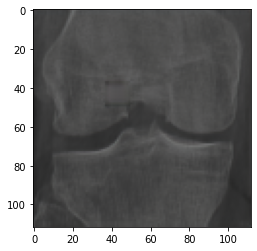

In [ ]:
#### show one inpainted image ###
%%time
im = sample_images[15]
impainted_image = unet_like.predict(im.reshape((1,)+im.shape))
plt.imshow(impainted_image.reshape(impainted_image.shape[1:]))

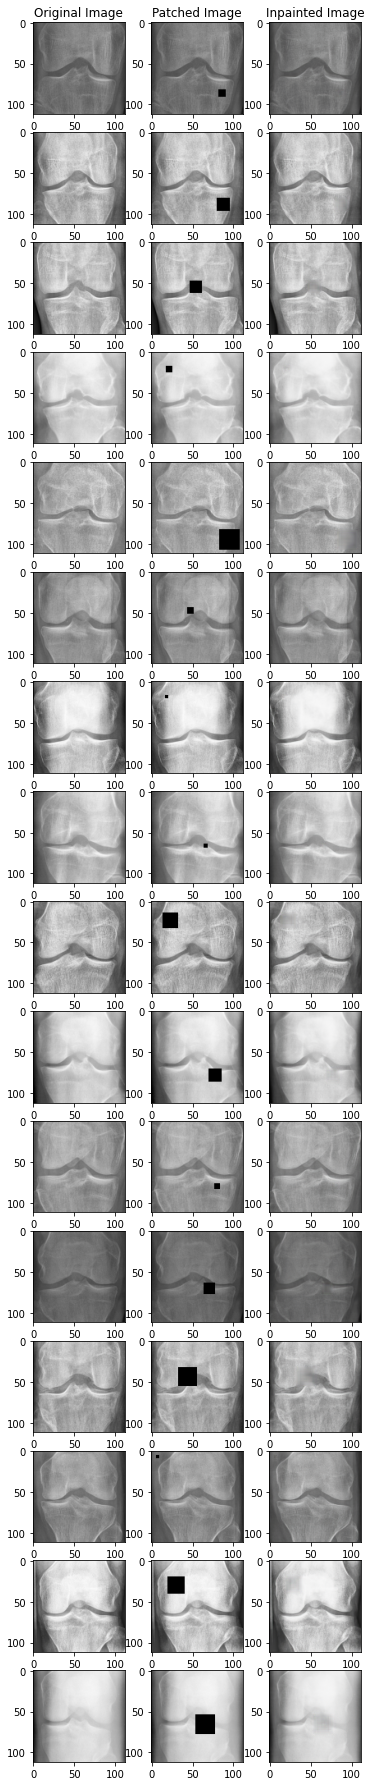

CPU times: user 7.73 s, sys: 481 ms, total: 8.22 s
Wall time: 7.89 s


In [ ]:
## Show  a series of original, patched and inpainted images ###
%%time
rows = 16
sample_idx = np.random.randint(0, len(testgen), rows)

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 32))

for i, idx in enumerate(sample_idx):
  sample_images, sample_labels = traingen[idx]
  img_idx = np.random.randint(0, len(sample_images)-1, 1)[0]
  impainted_image = unet_like.predict(sample_images[img_idx].reshape((1,)+sample_images[img_idx].shape))
  axs[i][0].imshow(sample_labels[img_idx]),axs[0][0].set_title('Original Image')
  axs[i][1].imshow(sample_images[img_idx]),axs[0][1].set_title('Patched Image')
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:])),axs[0][2].set_title('Inpainted Image')

plt.show()

# **Molel for inpainting in Pytorch**

In [ ]:
%%time
### convert train and test datasets from numpy array to tensor
traingen_tensor = torch.tensor(np.asarray(traingen))
print(traingen_tensor.shape)
testgen_tensor = torch.tensor(np.asarray(testgen))
print(testgen_tensor.shape)

torch.Size([53, 2, 112, 112, 112, 3])
torch.Size([13, 2, 112, 112, 112, 3])
CPU times: user 10.4 s, sys: 3.39 s, total: 13.8 s
Wall time: 12.9 s


**Unet model in Pytorch**

In [ ]:
%%time
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 3, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs

CPU times: user 65 µs, sys: 0 ns, total: 65 µs
Wall time: 72.7 µs


In [ ]:
device = 'cpu'       #### I had to change device to cpu, because the cuda had this error: 

###(CUDA out of memory. Tried to allocate 344.00 MiB (GPU 0; 15.90 GiB total capacity; 5.80 GiB already allocated; 175.75 MiB free; 
###6.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.
###See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF)

#Instantiate the model
Autoencoder = build_unet()
Autoencoder.to(device)
print(Autoencoder)

build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2

In [ ]:
#Loss function
criterion =   nn.BCEWithLogitsLoss()
#Optimizer
optimizer = optim.Adam(Autoencoder.parameters(), lr=0.001)
best_f1_score = 0

In [ ]:
%%time
for epoch in range(3):

    print(f'Epoch {epoch + 1}')

    Autoencoder.train()

    losses = list()

    for step, (dataa, labels) in enumerate(traingen_tensor):
        
        dataa=dataa.reshape(112,3,112,112)
        labels=labels.reshape(112,3,112,112)
        
        dataa = dataa.to(device=device, dtype=torch.float)
        labels = labels.to(device=device, dtype=torch.float)

        optimizer.zero_grad()
        logits = Autoencoder(dataa)
        loss = criterion(logits, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    print('\r[Training] Step {}: {:.6f}'.format(step, loss.item()), end='')

    print('\rLoss on Training Set: {:.6f}'.format(np.mean(losses)))

    Autoencoder.eval()

    y_true = None
    y_score = None

    #print('[Evaluating]', end='')

    for step, (dataa, labels) in enumerate(testgen_tensor):
        dataa=dataa.reshape(112,3,112,112)
        labels=labels.reshape(112,3,112,112)

        with torch.no_grad():
            dataa = dataa.to(device=device, dtype=torch.float)

            labels = labels.to(device=device, dtype=torch.float)

            logits = Autoencoder(dataa)
            predictions = torch.sigmoid(logits)

Epoch 1
Loss on Training Set: 0.602922
Epoch 2
Loss on Training Set: 0.595514
Epoch 3
Loss on Training Set: 0.594686
CPU times: user 5h 14min 51s, sys: 1min 45s, total: 5h 16min 36s
Wall time: 2h 38min 34s


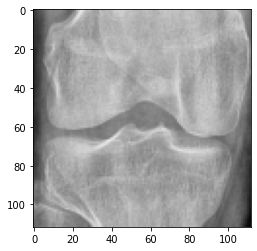

In [ ]:
### show one inpainted image ###
plt.imshow(labels[35].reshape(112,112,3))

CPU times: user 1.12 s, sys: 20.5 ms, total: 1.14 s
Wall time: 1.12 s


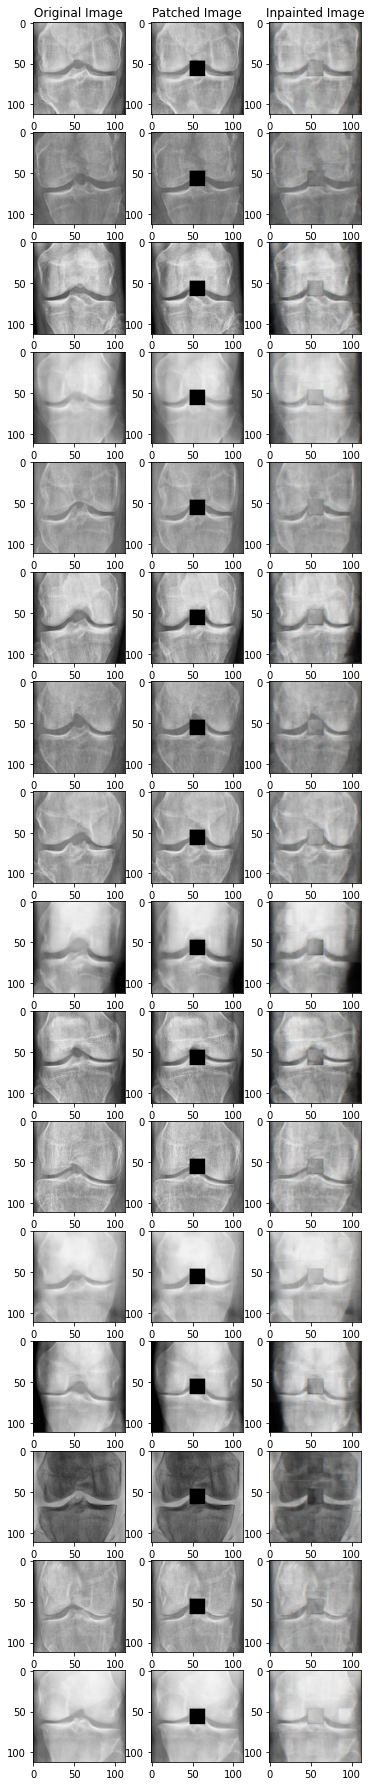

In [ ]:
## Show  a series of original, patched and inpainted images ###
%%time
rows = 16
sample_idx = np.random.randint(0, len(testgen), rows)

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 32))

for i, idx in enumerate(sample_idx):
  img_idx = np.random.randint(0, len(sample_images)-1, 1)[0]
  axs[i][0].imshow(labels[img_idx].reshape(112,112,3)),axs[0][0].set_title('Original Image')
  axs[i][1].imshow(dataa[img_idx].reshape(112,112,3)),axs[0][1].set_title('Patched Image')
  axs[i][2].imshow(predictions[img_idx].reshape(112,112,3)),axs[0][2].set_title('Inpainted Image')
